### VAE Implemenatation

References:
1. https://github.com/ac-alpha/VAEs-using-Pytorch

Collaborators: Jose Macalintal, Akib Khan

In [1]:
# import necessary packages
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from torch.autograd import Variable 
import torch.nn.functional as F 
import torchvision 
from torchvision import transforms 
import torch.optim as optim 
from torch import nn 
from torchvision.utils import make_grid

In [2]:
# define hyperparameters
num_epochs = 10
lr = 0.001

In [3]:
# load training and testing datasets from MNIST
training_set = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
testing_set = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
training_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=100, shuffle=True)
testing_loader = torch.utils.data.DataLoader(dataset=testing_set,  batch_size=100, shuffle=False)

In [4]:
# define VAE class
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()

        # encoder (28 x 28 = 728) 
        self.fc1 = nn.Linear(28*28, 512)

        # latent space parameters, mu and sigma 
        self.fc2_mu = nn.Linear(512, 2)
        self.fc2_sig = nn.Linear(512, 2)

        # decoder 
        self.fc3 = nn.Linear(2, 512)
        self.fc4 = nn.Linear(512, 784)
  
    def encoder(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decoder(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))

    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encoder(x.view(-1, 784))
        z = self.reparameterization(mu, logvar)
        return self.decoder(z), mu, logvar

# call the VAE
vae = VAE()

In [5]:
# define the loss function 
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, KLD 

# store the losses 
ELBO_loss = []
KL_loss = []
avg_ELBO_loss = []   # per epoch
avg_KL_loss = []   # per epoch 

In [6]:
# set the optimizer 
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [8]:
# train the model  
vae.train()

for epoch in range(num_epochs):
    
    train_loss = 0
    print_loss = 0
    kl_loss = 0
    
    for i, (images, _) in enumerate(training_loader):
        
        images = images.reshape(-1, 28*28)

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(images)
        loss, kl_loss  = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        if (epoch == 0):
            ELBO_loss.append(loss.item())
            KL_loss.append(kl_loss.item()) 
            
        train_loss += loss.item()
        print_loss += loss.item()
        kl_loss += kl_loss.item() 

        optimizer.step()

        # print the loss for each minibatch
        if (i % 100 == 0):
            print("Epoch : {} , Minibatch : {} ELBO Loss = {:.4f}, KL Loss = {:.4f}".format(epoch+1, i, print_loss, kl_loss))
            print_loss = 0

    # average loss per epoch 
    avg_loss = train_loss / len(training_loader.dataset) 
    avg_kl_loss = kl_loss / len(training_loader.dataset) 
    avg_ELBO_loss.append(avg_loss) 
    avg_KL_loss.append(avg_kl_loss) 

    # print loss at each epoch
    print("Epoch {} : ELBO Loss = ({:.4f}), KL Loss = {:.4f}".format(epoch+1, train_loss, kl_loss))

Epoch : 1 , Minibatch : 0 ELBO Loss = 55004.4219, KL Loss = 1.4369
Epoch : 1 , Minibatch : 100 ELBO Loss = 2234882.8145, KL Loss = 1199.3527
Epoch : 1 , Minibatch : 200 ELBO Loss = 1839852.1738, KL Loss = 1045.0281
Epoch : 1 , Minibatch : 300 ELBO Loss = 1779716.4043, KL Loss = 1051.1221
Epoch : 1 , Minibatch : 400 ELBO Loss = 1729714.4287, KL Loss = 999.5495
Epoch : 1 , Minibatch : 500 ELBO Loss = 1703831.8760, KL Loss = 1051.4149
Epoch 1 : ELBO Loss = (11014314.7227), KL Loss = 1063.8657
Epoch : 2 , Minibatch : 0 ELBO Loss = 16773.0527, KL Loss = 1010.9283
Epoch : 2 , Minibatch : 100 ELBO Loss = 1671574.8018, KL Loss = 1064.8054
Epoch : 2 , Minibatch : 200 ELBO Loss = 1662084.8203, KL Loss = 987.0253
Epoch : 2 , Minibatch : 300 ELBO Loss = 1656892.4756, KL Loss = 1013.6259
Epoch : 2 , Minibatch : 400 ELBO Loss = 1649661.3955, KL Loss = 992.1094
Epoch : 2 , Minibatch : 500 ELBO Loss = 1648424.9404, KL Loss = 1092.8970
Epoch 2 : ELBO Loss = (9921385.4619), KL Loss = 1021.4269
Epoch : 3

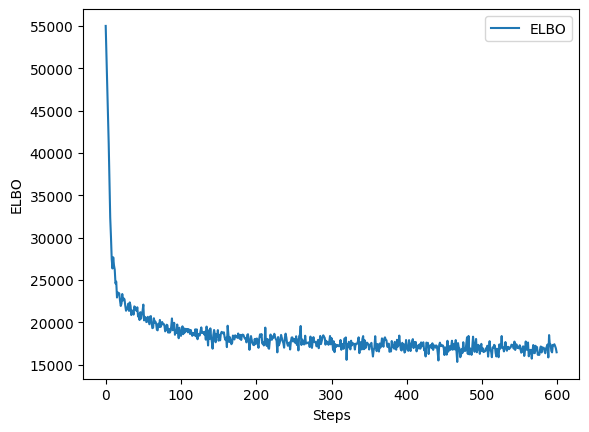

In [9]:
# plot ELBO loss
plt.plot(ELBO_loss, label = 'ELBO') 
plt.xlabel('Steps') 
plt.ylabel('ELBO') 
plt.legend()
plt.show()

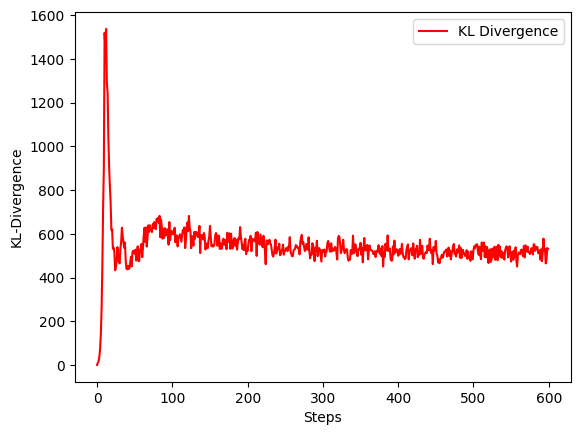

In [10]:
# plot KL divergence 
plt.plot(KL_loss, color = 'red', label = 'KL Divergence')
plt.xlabel('Steps') 
plt.ylabel('KL-Divergence') 
plt.legend()
plt.show() 

In [11]:
# define function to reconstruct MNIST images
def reconstruct_images(vae, data_loader, n_images=10):
    real_images, reconstructed_images = [], []
    vae.eval()
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(torch.float32)
            recon_batch, _, _ = vae(data)
            real_images = data[:n_images].view(-1, 1, 28, 28)
            reconstructed_images = recon_batch[:n_images].view(-1, 1, 28, 28)
            break
    return real_images, reconstructed_images

# define function to generate new images 
def generate_images(vae, n_images=10, latent_dim=2):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_images, latent_dim)
        generated_images = vae.decoder(z).view(-1, 1, 28, 28)
    return generated_images

# define function to compare real, reconstructed, and generated images
def image_comparison(real_images, reconstructed_images, generated_images):
    fig, axs = plt.subplots(3, len(real_images), figsize=(12, 6))

    for i in range(len(real_images)):
        axs[0, i].imshow(real_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title("Real")

        axs[1, i].imshow(reconstructed_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title("Reconstructed", fontsize = 11)

        axs[2, i].imshow(generated_images[i].squeeze().cpu().numpy(), cmap='gray')
        axs[2, i].axis('off')
        axs[2, i].set_title("Generated")

    plt.tight_layout() 
    plt.show()

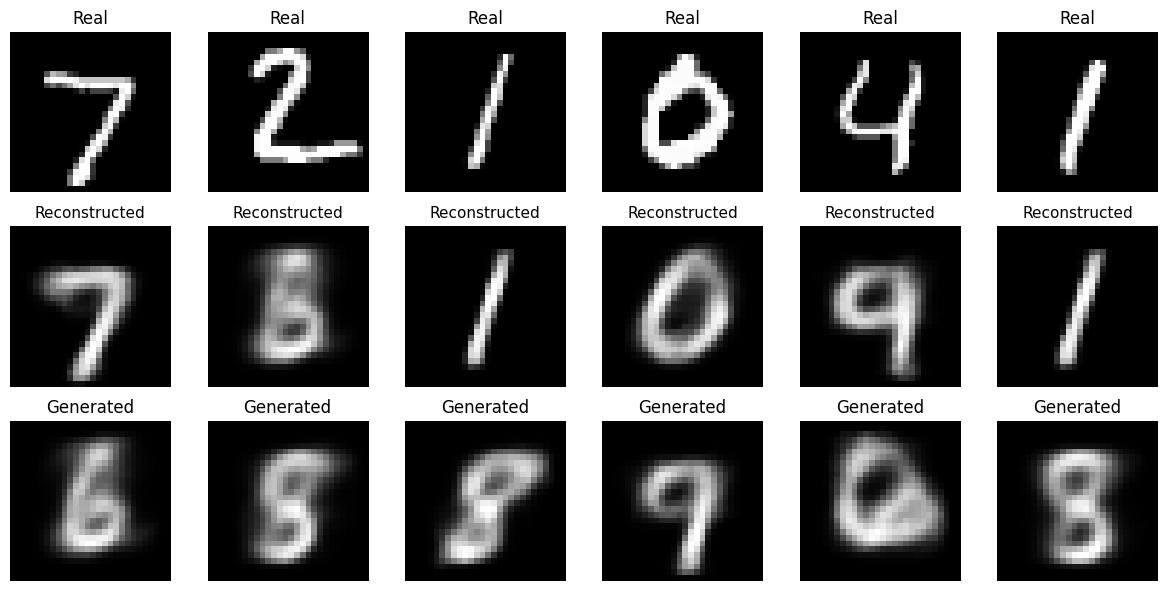

In [12]:
# visualize and compare results 
num_images = 6 
real_images, reconstructed_images = reconstruct_images(vae, testing_loader, num_images)
generated_images = generate_images(vae, num_images, latent_dim=2)
image_comparison(real_images, reconstructed_images, generated_images)

In [16]:
# define function to add noise to image
def add_noise(images, noise_factor=0.5): 
    noisy_images = images + noise_factor * torch.rand(*images.shape) 
    noisy_images = torch.clip(noisy_images, 0, 1) 
    return noisy_images

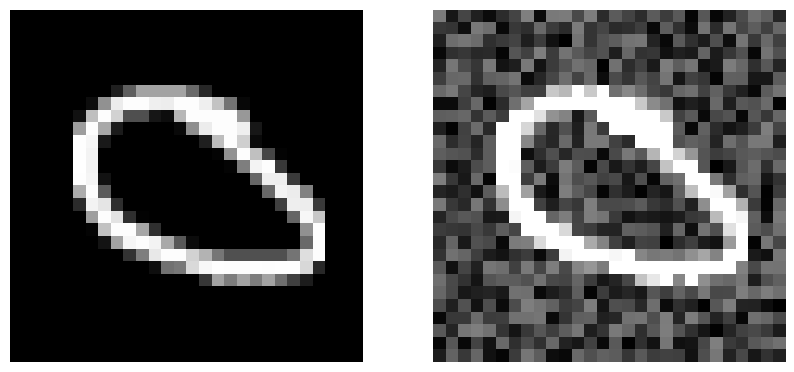

In [17]:
# generate normal and noisy images  
real_image, recon_image = reconstruct_images(vae, training_loader, n_images = 1) 
noise_image = add_noise(real_image) 

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(np.squeeze(real_image), cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(np.squeeze(noise_image), cmap='gray', vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

In [18]:
# define function to compute reconstruction error 
def compute_reconstruction_error(vae, images):
    images = images.to(torch.float32).reshape(-1, 28*28)
    with torch.no_grad():
        recon_images, _, _ = vae(images)
        error = ((recon_images - images) ** 2).sum(dim=(1))
    return error.cpu().numpy()

# define function to compute reconstruction errors for normal and noisy images 
def detect_anomalies(vae, data_loader, noise_factor=0.5):
    normal_errors, anomalous_errors = [], []
    vae.eval()

    # normal images
    for data, _ in data_loader:
        errors = compute_reconstruction_error(vae, data)
        normal_errors.extend(errors)
    
    # noisy images
    for data, _ in data_loader:
        noisy_data = add_noise(data, noise_factor)
        errors = compute_reconstruction_error(vae, noisy_data)
        anomalous_errors.extend(errors)
        if len(anomalous_errors) >= len(normal_errors):  
            anomalous_errors = anomalous_errors[:len(normal_errors)]
            break

    return np.array(normal_errors), np.array(anomalous_errors)

# define function to plot reconstruction error distributions and set anomaly threshold
def plot_error_distributions(normal_errors, anomalous_errors, threshold_value):
    plt.figure(figsize=(10, 6))
    plt.hist(normal_errors, bins=50, alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_errors, bins=50, alpha=0.6, color='red', label='Anomalous')
    plt.vlines(threshold_value, ymin = 0, ymax = 4500, colors = 'black', label = 'Threshold')  
    
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Distribution of Reconstruction Errors")
    plt.show()

# define function to classify images based on threshold
def classify_anomalies(errors, threshold):
    return errors > threshold

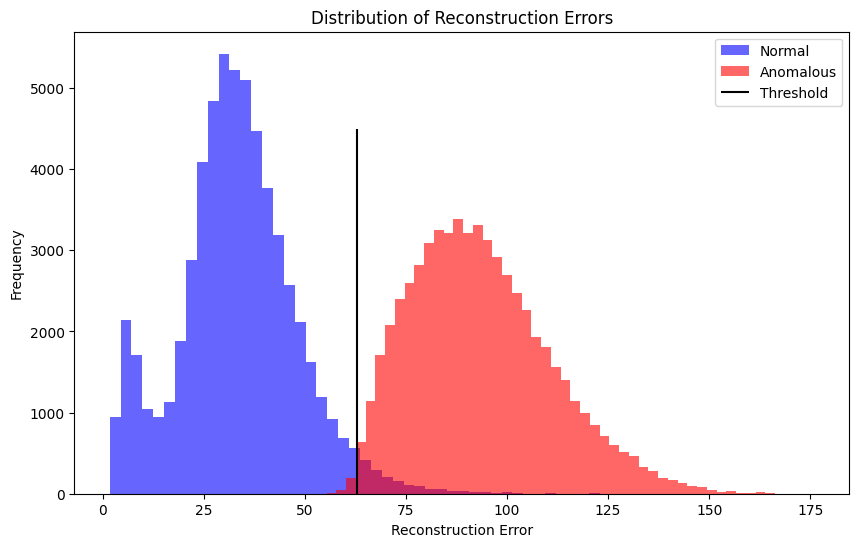

Anomaly Threshold: 63
False Positive Rate (Normal classified as Anomalous): 2.73%
True Positive Rate (Anomalous classified as Anomalous): 99.48%


In [21]:
# anomaly detection
normal_errors, anomalous_errors = detect_anomalies(vae, training_loader)
threshold = 63
plot_error_distributions(normal_errors, anomalous_errors, threshold)
print(f"Anomaly Threshold: {threshold}")

# classify normal and anomalous images based on threshold
normal_anomalies = classify_anomalies(normal_errors, threshold)
anomalous_anomalies = classify_anomalies(anomalous_errors, threshold)

# print detection rates
normal_detection_rate = 100 * np.sum(normal_anomalies) / len(normal_anomalies)
anomalous_detection_rate = 100 * np.sum(anomalous_anomalies) / len(anomalous_anomalies)
print(f"False Positive Rate (Normal classified as Anomalous): {normal_detection_rate:.2f}%")
print(f"True Positive Rate (Anomalous classified as Anomalous): {anomalous_detection_rate:.2f}%")

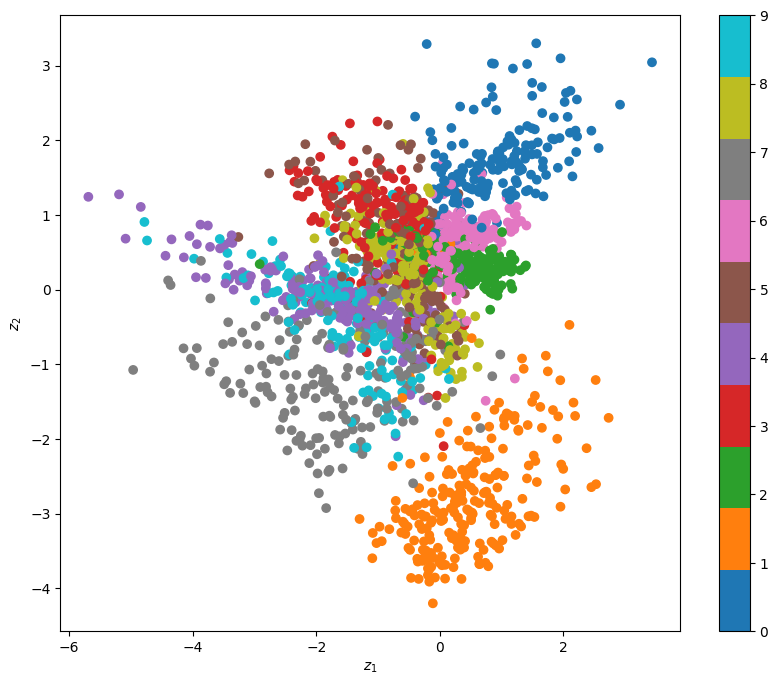

In [22]:
# latent space visualization
testing_set = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(), download=True)
testing_loader = torch.utils.data.DataLoader(dataset=testing_set, batch_size=2000, shuffle=False)

x_set, y_set = next(iter(testing_loader))
x_set = x_set.reshape(-1, 28*28)
z_set = vae.encoder(x_set)[0].detach().numpy()

plt.figure(figsize=(10, 8))
plt.scatter(z_set[:, 0], z_set[:, 1], c=y_set, cmap='tab10')
plt.colorbar()
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.show()